In [ ]:
import numpy as np

landmarks = np.load("/fsx/rs2517/data/HDTF/cropped_videos_original/WDA_ElijahCummings_000.npy")
landmarks.shape

In [8]:
from PIL import Image, ImageDraw, ImageFont


def create_landmarks_image_with_numbers_and_colors(landmarks, image_size=(772, 772), point_size=3, color_ranges=None):
    """
    Creates an image of landmarks on a black background, labels each landmark with its index,
    and colors specified ranges of landmarks differently using PIL.

video, audio, info = read_video("/fsx/rs2517/data/HDTF/cropped_videos_original/WDA_ElijahCummings_000.mp4")

/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


3.0600223541259766


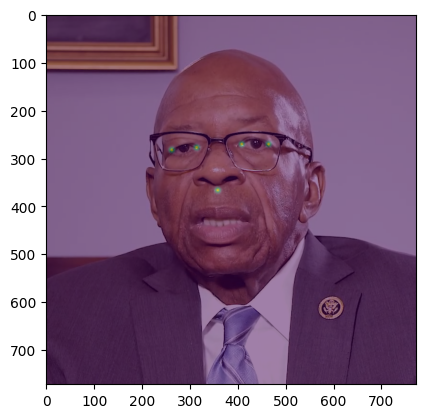

In [45]:
ALL_FIXED_POINTS = (
    [i for i in range(0, 4)] + [i for i in range(13, 17)] + [i for i in range(27, 36)] + [36, 39, 42, 45]
)
from functools import partial
import torch


# def gaussian_k(x0, y0, sigma, width, height):
#     """Make a square gaussian kernel centered at (x0, y0) with sigma as SD."""
#     x = torch.arange(0, width, 1)
#     y = torch.arange(0, height, 1).unsqueeze(1)
#     constant = -1 / (2 * sigma**2)
#     return torch.exp(constant * ((x - x0) ** 2 + (y - y0) ** 2))


# # https://www.researchgate.net/figure/Example-face-image-annotated-with-68-landmarks_fig1_37434867
# def generate_hm(landmarks, height, width, n_points="all", sigma=3):
#     if n_points == "all":
#         Nlandmarks = range(len(landmarks))
#     elif n_points == "fixed":
#         Nlandmarks = ALL_FIXED_POINTS
#     elif n_points == "stable":
#         Nlandmarks = [33, 36, 39, 42, 45]
#     hm = torch.zeros((height, width))
#     for i in Nlandmarks:
#         hm += gaussian_k(landmarks[i][0], landmarks[i][1], sigma, width, height)

#     return hm

import torch


def gaussian_kernel(sigma, width, height):
    """Create a 2D Gaussian kernel."""
    x = torch.arange(0, width, 1) - width // 2
    y = torch.arange(0, height, 1) - height // 2
    x = x.float()
    y = y.float()
    x2 = x**2
    y2 = y[:, None] ** 2
    g = torch.exp(-(x2 + y2) / (2 * sigma**2))
    return g / g.sum()


def generate_hm(landmarks, height, width, n_points="all", sigma=3):
    if n_points == "all":
        Nlandmarks = range(len(landmarks))
    elif n_points == "fixed":
        Nlandmarks = ALL_FIXED_POINTS
    elif n_points == "stable":
        Nlandmarks = [33, 36, 39, 42, 45]

    kernel = gaussian_kernel(sigma, width, height)
    hm = torch.zeros((height, width))
    for I in Nlandmarks:
        x0, y0 = landmarks[I]
        x0, y0 = int(x0), int(y0)
        left, right = max(0, x0 - width // 2), min(width, x0 + width // 2)
        top, bottom = max(0, y0 - height // 2), min(height, y0 + height // 2)
        hm[top:bottom, left:right] += kernel[
            max(0, -y0 + height // 2) : min(height, height - y0 + height // 2),
            max(0, -x0 + width // 2) : min(width, width - x0 + width // 2),
        ]

    # Normalize the heatmap to have values between 0 and 1
    max_val = hm.max()
    if max_val > 0:
        hm /= max_val
    return hm


def get_heatmap(landmarks, image_size, n_points="all", sigma=4):
    stack = []
    seq_length = landmarks.shape[0]
    gen_single_heatmap = partial(
        generate_hm,
        height=image_size[0],
        width=image_size[1],
        n_points=n_points,
        sigma=sigma,
    )
    for i in range(seq_length):
        stack.append(gen_single_heatmap(landmarks[i]))

    return torch.stack(stack, axis=0).unsqueeze(0)


frame = 2000
import time

start = time.time()
heatmap = get_heatmap(landmarks[frame : frame + 100], (772, 772), n_points="stable", sigma=4)
print(time.time() - start)
heatmap.shape

# display first frame on top of original image
import matplotlib.pyplot as plt

plt.imshow(heatmap[0, 0].numpy())
plt.imshow(video[frame], alpha=0.5)
plt.show()

In [46]:
heatmap.max(), heatmap.min()

(6375, 772, 772)


(tensor(1.), tensor(0.))

In [3]:
def scale_landmarks(landmarks, original_size, target_size):
    """
    Scale landmarks from original size to target size.

    Parameters:
    - landmarks (np.array): An array of shape (N, 2) containing facial landmarks.
    - original_size (tuple): The size (height, width) for which the landmarks are currently scaled.
    - target_size (tuple): The size (height, width) to which landmarks should be scaled.

    Returns:
    - scaled_landmarks (np.array): Scaled landmarks.
    """
    scale_y = target_size[0] / original_size[0]
    scale_x = target_size[1] / original_size[1]
    scaled_landmarks = landmarks * np.array([scale_x, scale_y])
    return scaled_landmarks.astype(int)


def create_landmarks_image(landmarks, original_size=(772, 772), target_size=(772, 772), point_size=3):
    """
    Creates an image of landmarks on a black background using efficient NumPy operations.

    Parameters:
    - landmarks (np.array): An array of shape (68, 2) containing facial landmarks.
    - image_size (tuple): The size of the output image (height, width).
    - point_size (int): The radius of each landmark point in pixels.

    Returns:
    - img (np.array): An image array with landmarks plotted.
    """
    img = np.zeros(target_size, dtype=np.uint8)

    landmarks = scale_landmarks(landmarks, original_size, target_size)

    # Ensure the landmarks are in bounds and integer
    landmarks = np.clip(landmarks, [0, 0], [target_size[1] - 1, target_size[0] - 1]).astype(int)

    # Get x and y coordinates from landmarks
    x, y = landmarks[:, 0], landmarks[:, 1]

    # Define a grid offset based on point_size around each landmark
    offset = np.arange(-point_size // 2, point_size // 2 + 1)
    grid_x, grid_y = np.meshgrid(offset, offset, indexing="ij")

    # Calculate the full set of x and y coordinates for the points
    full_x = x[:, np.newaxis, np.newaxis] + grid_x[np.newaxis, :, :]
    full_y = y[:, np.newaxis, np.newaxis] + grid_y[np.newaxis, :, :]

    # Clip the coordinates to stay within image boundaries
    full_x = np.clip(full_x, 0, target_size[1] - 1)
    full_y = np.clip(full_y, 0, target_size[0] - 1)

    # Flatten the arrays to use them as indices
    full_x = full_x.ravel()
    full_y = full_y.ravel()

    # Set the points in the image
    img[full_y, full_x] = 255

    return np.stack([img] * 3, axis=0)


landmarks_image = create_landmarks_image(landmarks[0], target_size=(224, 224), point_size=2)

In [ ]:
from PIL import Image

landmarks_image_rescaled = (landmarks_image.transpose(1, 2, 0) / 255.0) * 2 - 1
landmarks_image_rescaled = np.clip(landmarks_image_rescaled, -1, 1)
landmarks_image_rescaled = ((landmarks_image_rescaled + 1) / 2 * 255).astype(np.uint8)

# Display the the landmarks with number on landmarks
img = Image.fromarray(landmarks_image_rescaled

(512, 512, 3) uint8


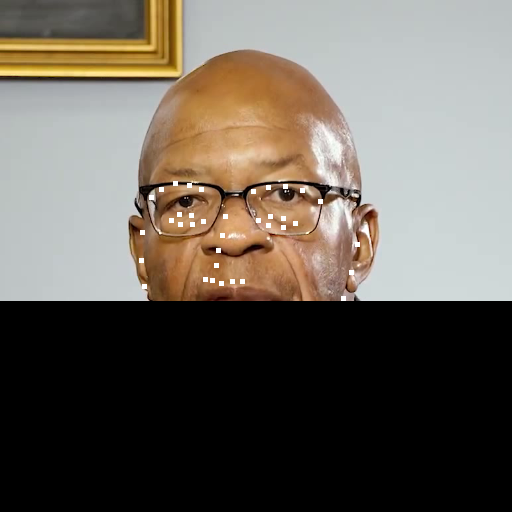

(512, 512, 3) uint8


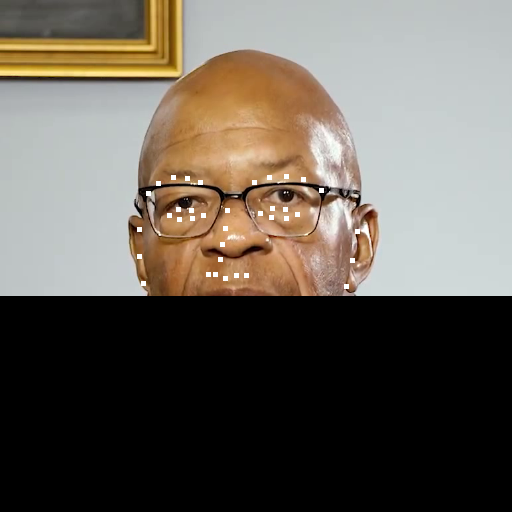

(512, 512, 3) uint8


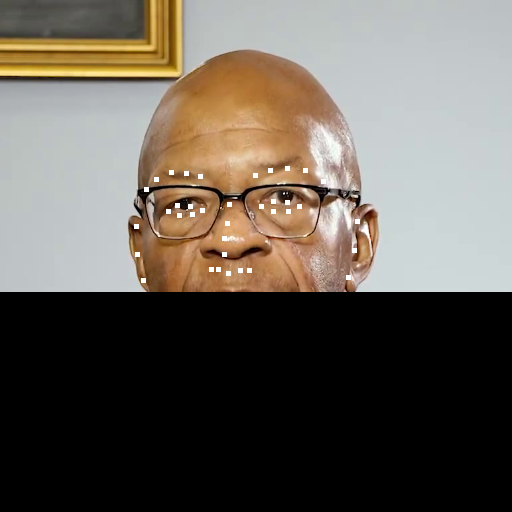

(512, 512, 3) uint8


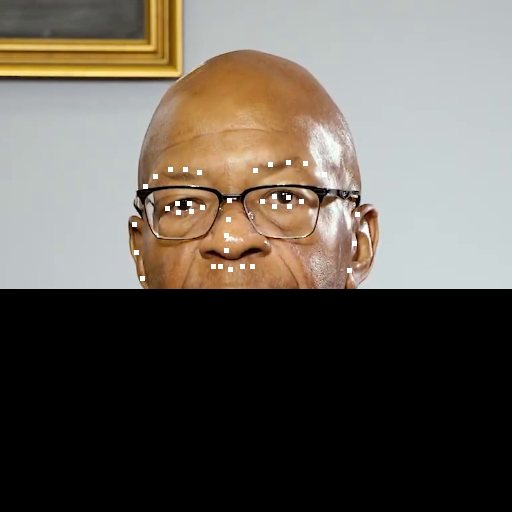

(512, 512, 3) uint8


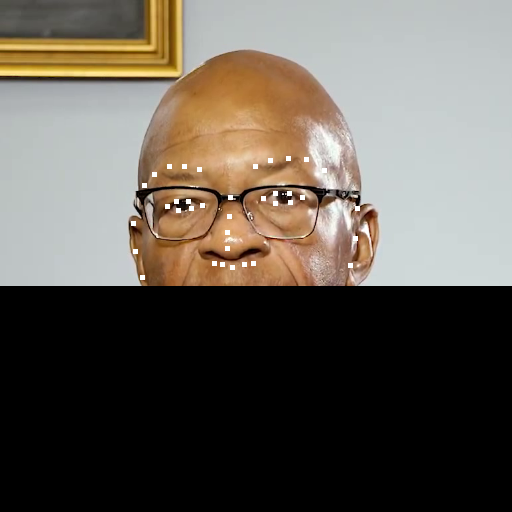

(512, 512, 3) uint8


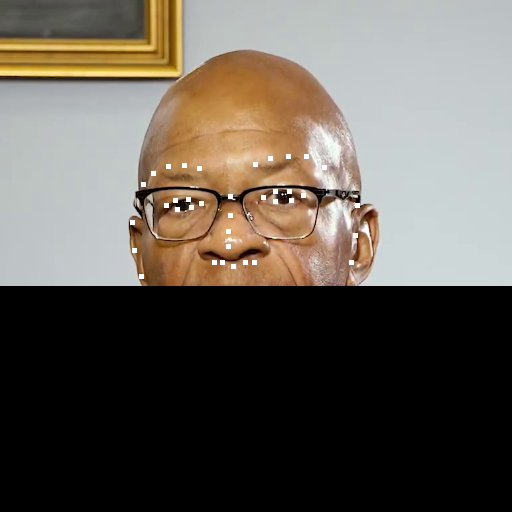

(512, 512, 3) uint8


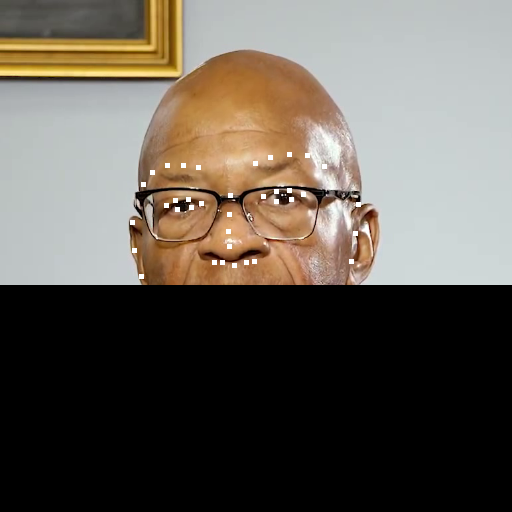

(512, 512, 3) uint8


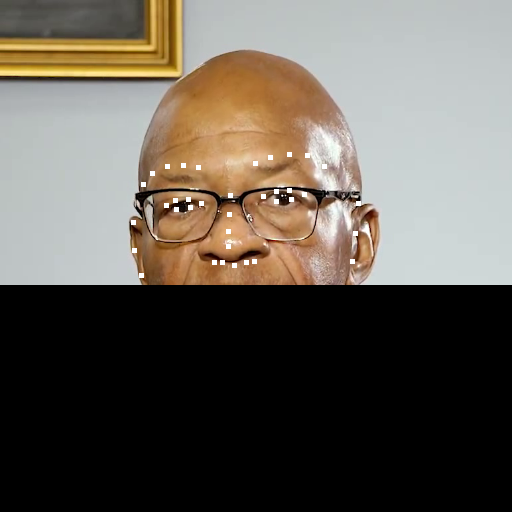

(512, 512, 3) uint8


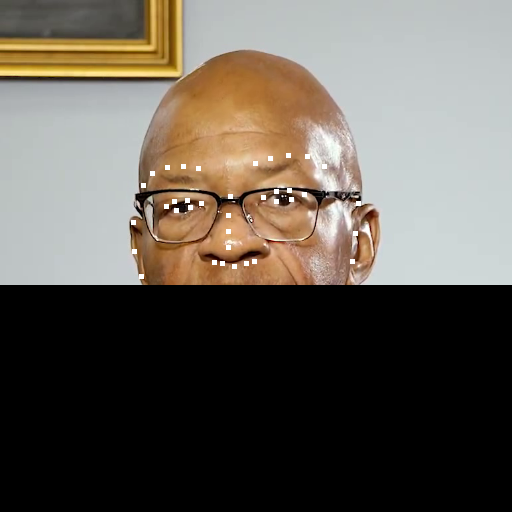

(512, 512, 3) uint8


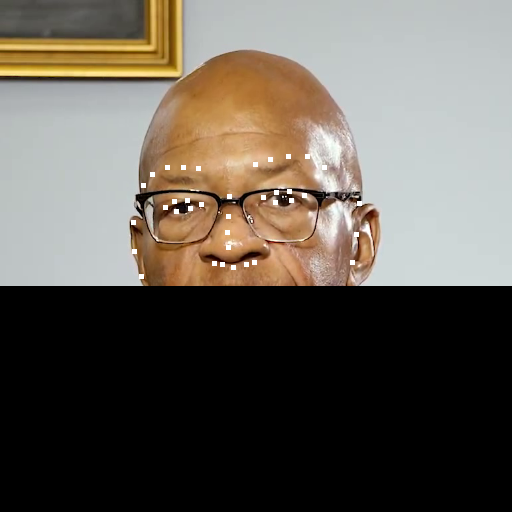

In [62]:
def scale_landmarks(landmarks, original_size, target_size):
    """
    Scale landmarks from original size to target size.

    Parameters:
    - landmarks (np.array): An array of shape (N, 2) containing facial landmarks.
    - original_size (tuple): The size (height, width) for which the landmarks are currently scaled.
    - target_size (tuple): The size (height, width) to which landmarks should be scaled.

    Returns:
    - scaled_landmarks (np.array): Scaled landmarks.
    """
    scale_y = target_size[0] / original_size[0]
    scale_x = target_size[1] / original_size[1]
    scaled_landmarks = landmarks * np.array([scale_x, scale_y])
    return scaled_landmarks.astype(int)


def create_landmarks_image(landmarks, original_size=(772, 772), target_size=(772, 772), point_size=3):
    """
    Creates an image of landmarks on a black background using efficient NumPy operations.

    Parameters:
    - landmarks (np.array): An array of shape (68, 2) containing facial landmarks.
    - image_size (tuple): The size of the output image (height, width).
    - point_size (int): The radius of each landmark point in pixels.

    Returns:
    - img (np.array): An image array with landmarks plotted.
    """
    img = np.zeros(target_size, dtype=np.uint8)

    scaled_landmarks = scale_landmarks(landmarks, original_size, target_size)

    # Ensure the landmarks are in bounds and integer
    landmarks = np.clip(scaled_landmarks, [0, 0], [target_size[1] - 1, target_size[0] - 1]).astype(int)

    # Get x and y coordinates from landmarks
    x, y = landmarks[:, 0], landmarks[:, 1]

    # Define a grid offset based on point_size around each landmark
    offset = np.arange(-point_size // 2, point_size // 2 + 1)
    grid_x, grid_y = np.meshgrid(offset, offset, indexing="ij")

    # Calculate the full set of x and y coordinates for the points
    full_x = x[:, np.newaxis, np.newaxis] + grid_x[np.newaxis, :, :]
    full_y = y[:, np.newaxis, np.newaxis] + grid_y[np.newaxis, :, :]

    # Clip the coordinates to stay within image boundaries
    full_x = np.clip(full_x, 0, target_size[1] - 1)
    full_y = np.clip(full_y, 0, target_size[0] - 1)

    # Flatten the arrays to use them as indices
    full_x = full_x.ravel()
    full_y = full_y.ravel()

    # Set the points in the image
    img[full_y, full_x] = 255

    return np.stack([img] * 3, axis=-1)


def overlay_landmarks_on_tensor(original_tensor, landmarks, point_size=3):
    """
    Overlay landmarks on an existing image tensor.

    Parameters:
    - original_tensor (np.array): Original image tensor of shape (772, 772, 3).
    - landmarks (np.array): An array of shape (68, 2) containing facial landmarks.
    - point_size (int): Diameter of each landmark point.

    Returns:
    - overlaid_image (np.array): Image tensor with landmarks overlaid.
    """
    landmarks_image = create_landmarks_image(
        landmarks, target_size=(original_tensor.shape[1], original_tensor.shape[0]), point_size=point_size
    )
    landmarks_array = np.array(landmarks_image)

    # Overlay the landmarks on the original image
    overlaid_image = np.maximum(original_tensor, landmarks_array)
    return overlaid_image


offset = 0
for i in range(10):
    overlayed = overlay_landmarks_on_tensor(video[offset + i].numpy(), landmarks[offset + i], point_size=4) * (
        1 - masks[offset + i, :, :, None]
    ).astype(np.uint8)
    print(overlayed.shape, overlayed.dtype)
    display(Image.fromarray(overlayed))